<a href="https://colab.research.google.com/github/Arunesh062/DL/blob/main/DLL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required packages
!pip install tensorflow pandas numpy matplotlib scikit-learn


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Dense, LayerNormalization, MultiHeadAttention, Add, Reshape, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb


# Check GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [ ]:
# Load CSV
df = pd.read_csv('/content/ZENTEC.NS.csv')

# Inspect the first rows
print(df.head())

# Since this dataset is already for a single stock, we don't filter by Symbol
df_stock = df.copy()

# Select relevant columns
df_stock = df_stock[['Date','Open','High','Low','Close','Volume']]

# Convert 'Date' to datetime format
df_stock['Date'] = pd.to_datetime(df_stock['Date'])

# Sort by Date
df_stock = df_stock.sort_values('Date').reset_index(drop=True)

# Inspect cleaned data
print(df_stock.head())


                        Date       Open       High        Low      Close  \
0  2015-03-30 00:00:00+05:30  47.888229  55.999908  47.888229  53.752094   
1  2015-03-31 00:00:00+05:30  55.413521  57.172680  53.752092  54.680538   
2  2015-04-01 00:00:00+05:30  56.097644  56.097644  52.921383  54.436214   
3  2015-04-06 00:00:00+05:30  55.951044  65.284365  55.218061  62.254700   
4  2015-04-07 00:00:00+05:30  62.499017  70.366367  61.570571  67.874222   

   Volume  Dividends  Stock Splits  
0   59509        0.0           0.0  
1  137591        0.0           0.0  
2  148767        0.0           0.0  
3  308258        0.0           0.0  
4  281312        0.0           0.0  
                       Date       Open       High        Low      Close  \
0 2015-03-30 00:00:00+05:30  47.888229  55.999908  47.888229  53.752094   
1 2015-03-31 00:00:00+05:30  55.413521  57.172680  53.752092  54.680538   
2 2015-04-01 00:00:00+05:30  56.097644  56.097644  52.921383  54.436214   
3 2015-04-06 00:00:00

In [ ]:
# RSI function
def compute_RSI(series, period=14):
    delta = series.diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    avg_gain = pd.Series(gain).rolling(window=period, min_periods=1).mean()
    avg_loss = pd.Series(loss).rolling(window=period, min_periods=1).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Add features to df_stock
df_stock['Return'] = df_stock['Close'].pct_change()
df_stock['MA5'] = df_stock['Close'].rolling(window=5).mean()
df_stock['MA10'] = df_stock['Close'].rolling(window=10).mean()
df_stock['STD5'] = df_stock['Close'].rolling(window=5).std()
df_stock['STD10'] = df_stock['Close'].rolling(window=10).std()
df_stock['RSI'] = compute_RSI(df_stock['Close'], 14)
df_stock['Momentum'] = df_stock['Close'] - df_stock['Close'].shift(10)
# Add lagged returns (t-1 to t-5)
for lag in range(1, 10000):
    df_stock[f'Return_lag{lag}'] = df_stock['Return'].shift(lag)

# Drop rows with NaN due to lag
df_stock = df_stock.dropna()


# Label: 1 if next day Close increases >0.5%
threshold = 0.005
df_stock['Trend'] = np.where(df_stock['Close'].shift(-1)/df_stock['Close'] - 1 > threshold, 1, 0)
df_stock = df_stock[:-1]  # drop last row


# Include all engineered features
features = df_stock[['Open','High','Low','Close','Volume',
                     'Return','MA5','MA10','STD5','STD10','RSI','Momentum']].values
target = df_stock['Trend'].values

# Scale features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
def create_windows(data, labels, window_size=90):
    X = []
    y = []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(labels[i+window_size])
    return np.array(X), np.array(y)

window_size = 90  # longer sequence helps capture trends
X, y = create_windows(features_scaled, target, window_size)
df_stock['News_Sentiment'] = 0  # placeholder


# X = [price_features + technical_indicators + news_sentiment]  # shape: (num_samples, window_size, num_features)
# y = Trend


print("X shape:", X.shape)  # (samples, 90, num_features)
print("y shape:", y.shape)


ValueError: Found array with 0 sample(s) (shape=(0, 12)) while a minimum of 1 is required by StandardScaler.

In [ ]:
features = df_stock[['Open','High','Low','Close','Volume',
                     'Return','MA5','MA10','STD5','STD10','RSI','Momentum',
                     'Return_lag1','Return_lag2','Return_lag3','Return_lag4','Return_lag5',
                     'News_Sentiment']]

target = df_stock['Trend']

# Train-test split (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, shuffle=False)

# Scale features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

xgb_model = xgb.XGBClassifier(
    n_estimators=700,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    use_label_encoder=False
)

xgb_model.fit(X_train_scaled, y_train)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [06:16:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=700, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
y_pred = xgb_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy*100, "%")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


Test Accuracy: 61.75972927241963 %
              precision    recall  f1-score   support

           0       0.63      0.95      0.76       371
           1       0.41      0.06      0.11       220

    accuracy                           0.62       591
   macro avg       0.52      0.50      0.43       591
weighted avg       0.55      0.62      0.52       591

[[351  20]
 [206  14]]


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense

# Number of features
num_price_features = X_train.shape[2]  # 12 features (OHLCV + indicators)
window_size = X_train.shape[1]         # 90

# Input layer
price_input = Input(shape=(window_size, num_price_features))

# LSTM layers
x = LSTM(64, return_sequences=False)(price_input)
output = Dense(1, activation='sigmoid')(x)

# Model
model = Model(inputs=price_input, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 90, 12)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        19,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,777 (77.25 KB)

 Trainable params: 19,777 (77.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop]
)

# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_acc*100, "%")


Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.5863 - loss: 0.6780 - val_accuracy: 0.5977 - val_loss: 0.6666
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6129 - loss: 0.6720 - val_accuracy: 0.5939 - val_loss: 0.6597
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6405 - loss: 0.6466 - val_accuracy: 0.6092 - val_loss: 0.6599
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6520 - loss: 0.6367 - val_accuracy: 0.6322 - val_loss: 0.6582
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6431 - loss: 0.6432 - val_accuracy: 0.6207 - val_loss: 0.6785
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6360 - loss: 0.6547 - val_accuracy: 0.6130 - val_loss: 0.6619
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6411 - loss: 0.6407 - val_accuracy: 0.6207 - val_loss: 0.6664
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6516 - loss: 0.6395 - val_accuracy: 0.6130 - val_loss

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6474 - loss: 0.7050 
Test Accuracy: 67.18%
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


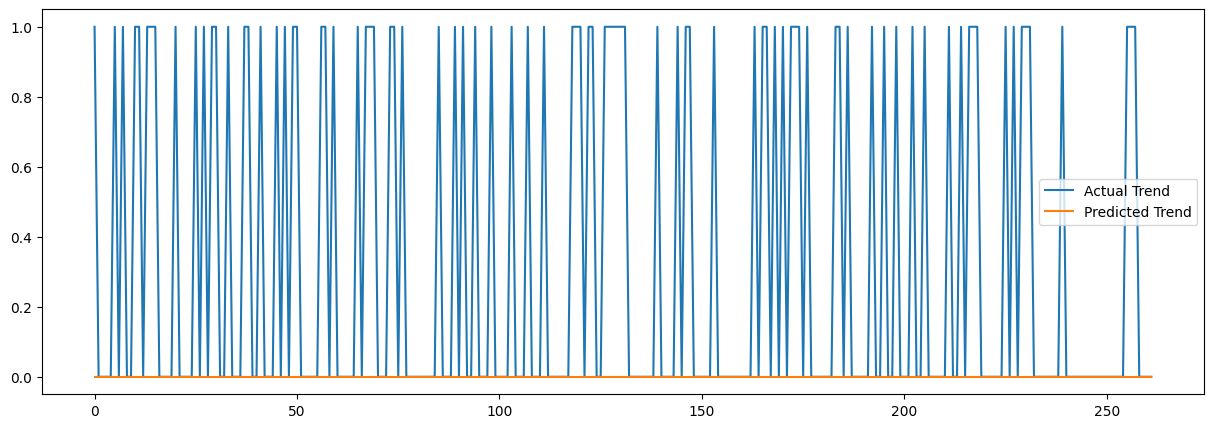

In [ ]:
# Test accuracy
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc*100:.2f}%")

# Predictions
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Visualize predictions vs actual
plt.figure(figsize=(15,5))
plt.plot(y_test, label='Actual Trend')
plt.plot(y_pred, label='Predicted Trend')
plt.legend()
plt.show()
